Code Source: https://wiseodd.github.io/techblog/2016/12/24/conditional-gan-tensorflow/

In Russian: https://habr.com/ru/post/332000/

In [1]:
import tensorflow as tf
import pathlib

AUTOTUNE = tf.contrib.data.AUTOTUNE

D:\Programming\ANACONDA3\envs\GAN\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Programming\ANACONDA3\envs\GAN\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Programming\ANACONDA3\envs\GAN\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Programming\ANACONDA3\envs\GAN\lib\site-packages\tensorflow\python\framework

## Data preparation

In [2]:
# Give a look to the consistence of the input data folder
data_root = pathlib.Path("D:\Programming\Jupyter Notebook Works\GANs\cGAN\Input_car_train")

# Iterate all objects from the folder
for item in data_root.iterdir():
    print(item)

D:\Programming\Jupyter Notebook Works\GANs\cGAN\Input_car_train\back
D:\Programming\Jupyter Notebook Works\GANs\cGAN\Input_car_train\front
D:\Programming\Jupyter Notebook Works\GANs\cGAN\Input_car_train\side


In [3]:
import random
all_image_paths = list(data_root.glob('*/*')) #iterate objects from the path
all_image_paths = [str(path) for path in all_image_paths] #exchange all obtained names to "str"
random.shuffle(all_image_paths) #randomly shuffle the list
# all_image_paths

# Let's count how many images do we have as input
image_count = len(all_image_paths)
image_count

270

In [4]:
# What did we obtain since now?
all_image_paths[:10]

['D:\\Programming\\Jupyter Notebook Works\\GANs\\cGAN\\Input_car_train\\side\\IMG_20191016_120108_BURST13.jpg',
 'D:\\Programming\\Jupyter Notebook Works\\GANs\\cGAN\\Input_car_train\\side\\IMG_20191016_120112_BURST2.jpg',
 'D:\\Programming\\Jupyter Notebook Works\\GANs\\cGAN\\Input_car_train\\side\\IMG_20191016_120119_BURST1.jpg',
 'D:\\Programming\\Jupyter Notebook Works\\GANs\\cGAN\\Input_car_train\\back\\IMG_20191016_120238_BURST3.jpg',
 'D:\\Programming\\Jupyter Notebook Works\\GANs\\cGAN\\Input_car_train\\front\\IMG_20191016_120152_BURST11.jpg',
 'D:\\Programming\\Jupyter Notebook Works\\GANs\\cGAN\\Input_car_train\\front\\IMG_20191016_120142_BURST11.jpg',
 'D:\\Programming\\Jupyter Notebook Works\\GANs\\cGAN\\Input_car_train\\side\\IMG_20191016_120108_BURST12.jpg',
 'D:\\Programming\\Jupyter Notebook Works\\GANs\\cGAN\\Input_car_train\\side\\IMG_20191016_120112_BURST19.jpg',
 'D:\\Programming\\Jupyter Notebook Works\\GANs\\cGAN\\Input_car_train\\side\\IMG_20191016_120116_BURST13

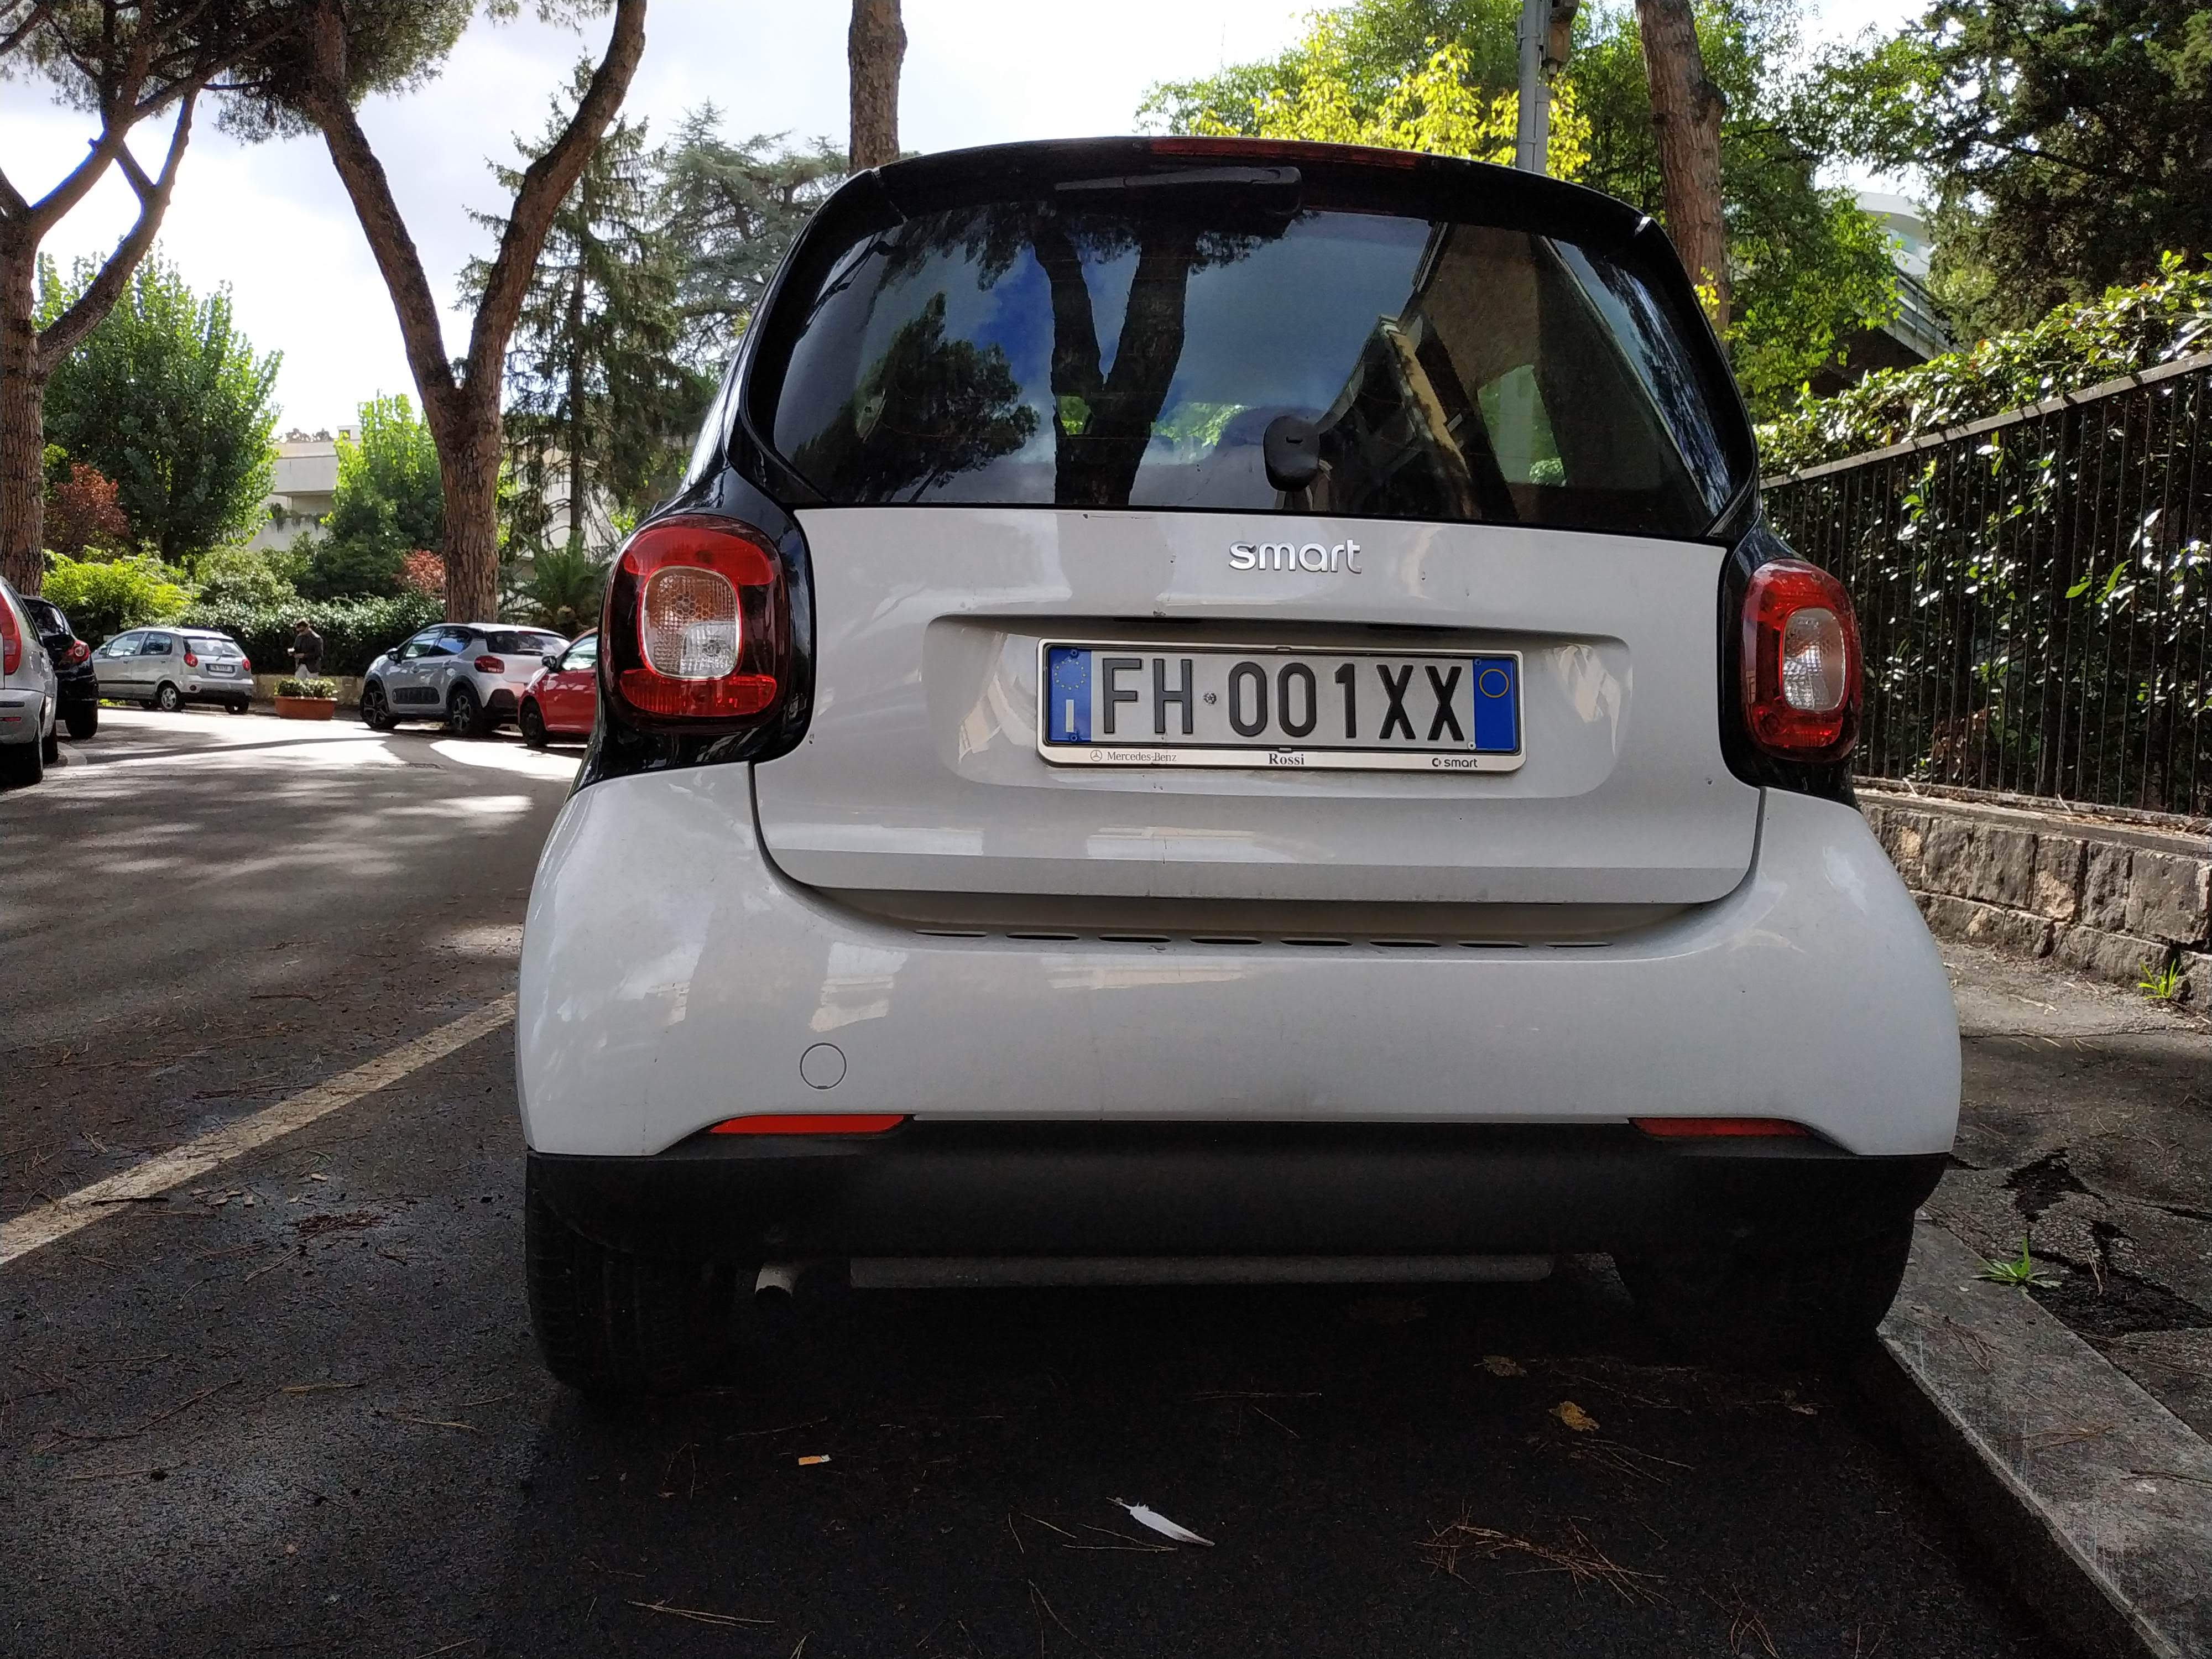

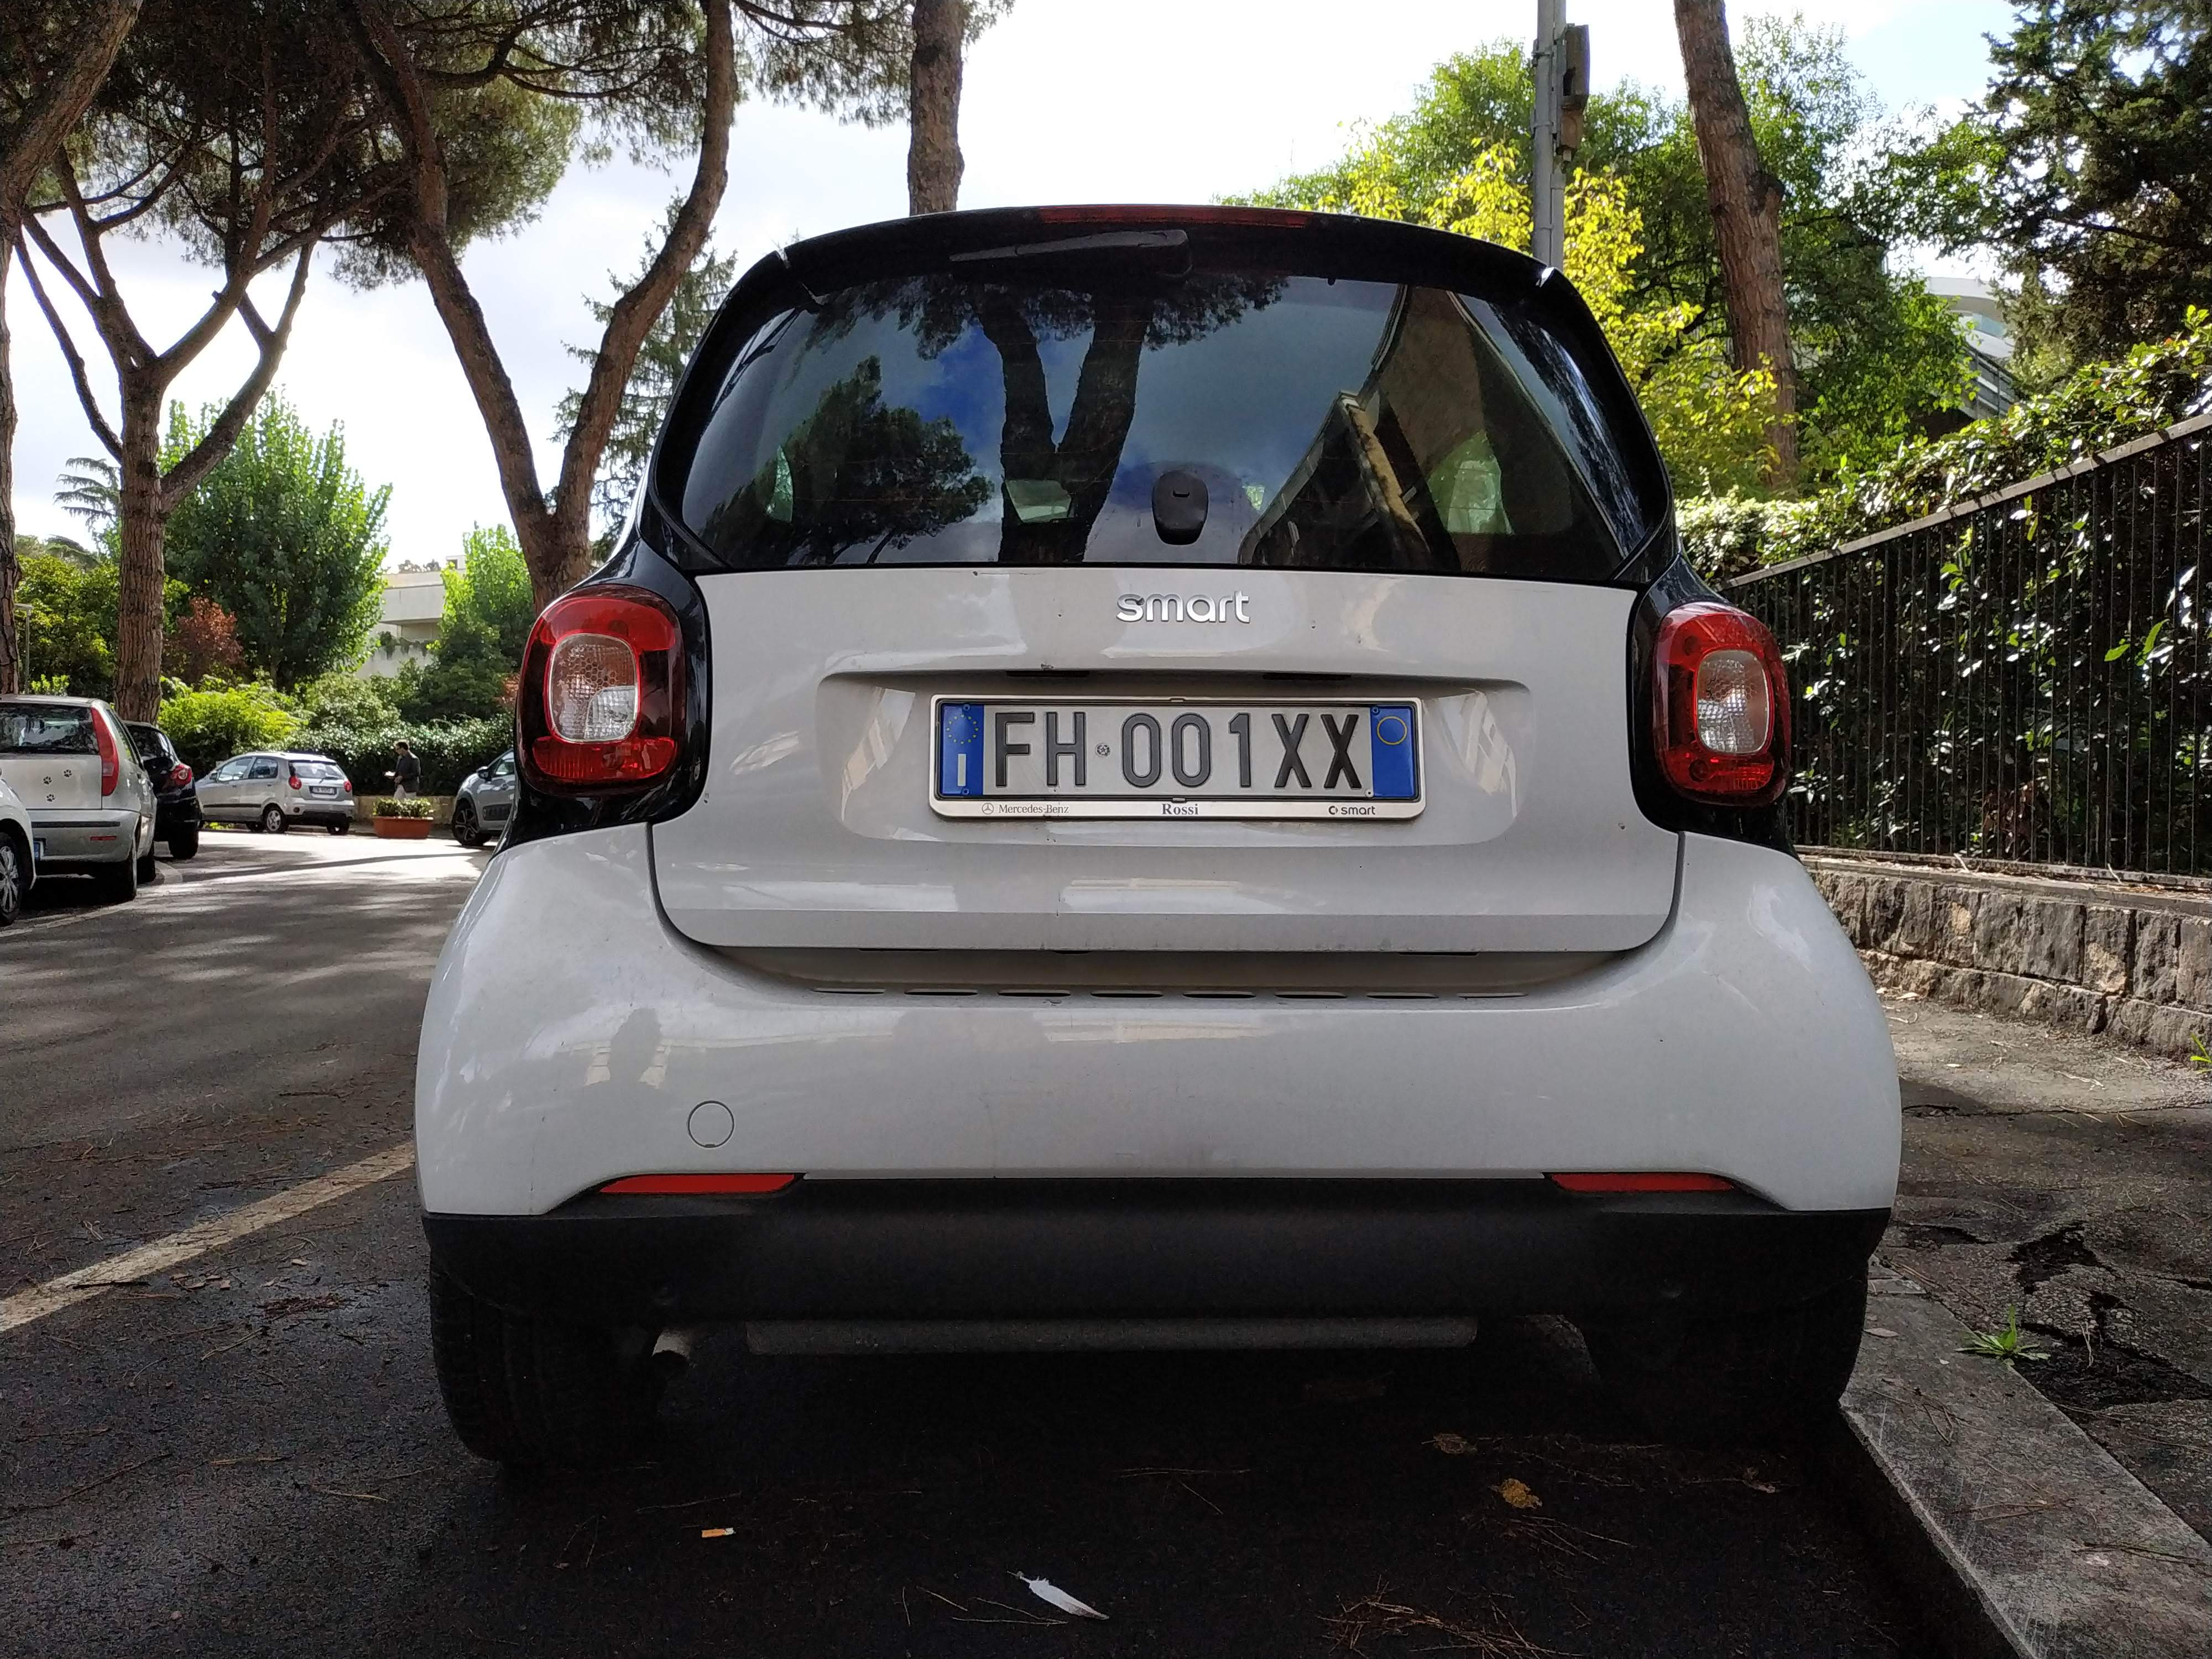

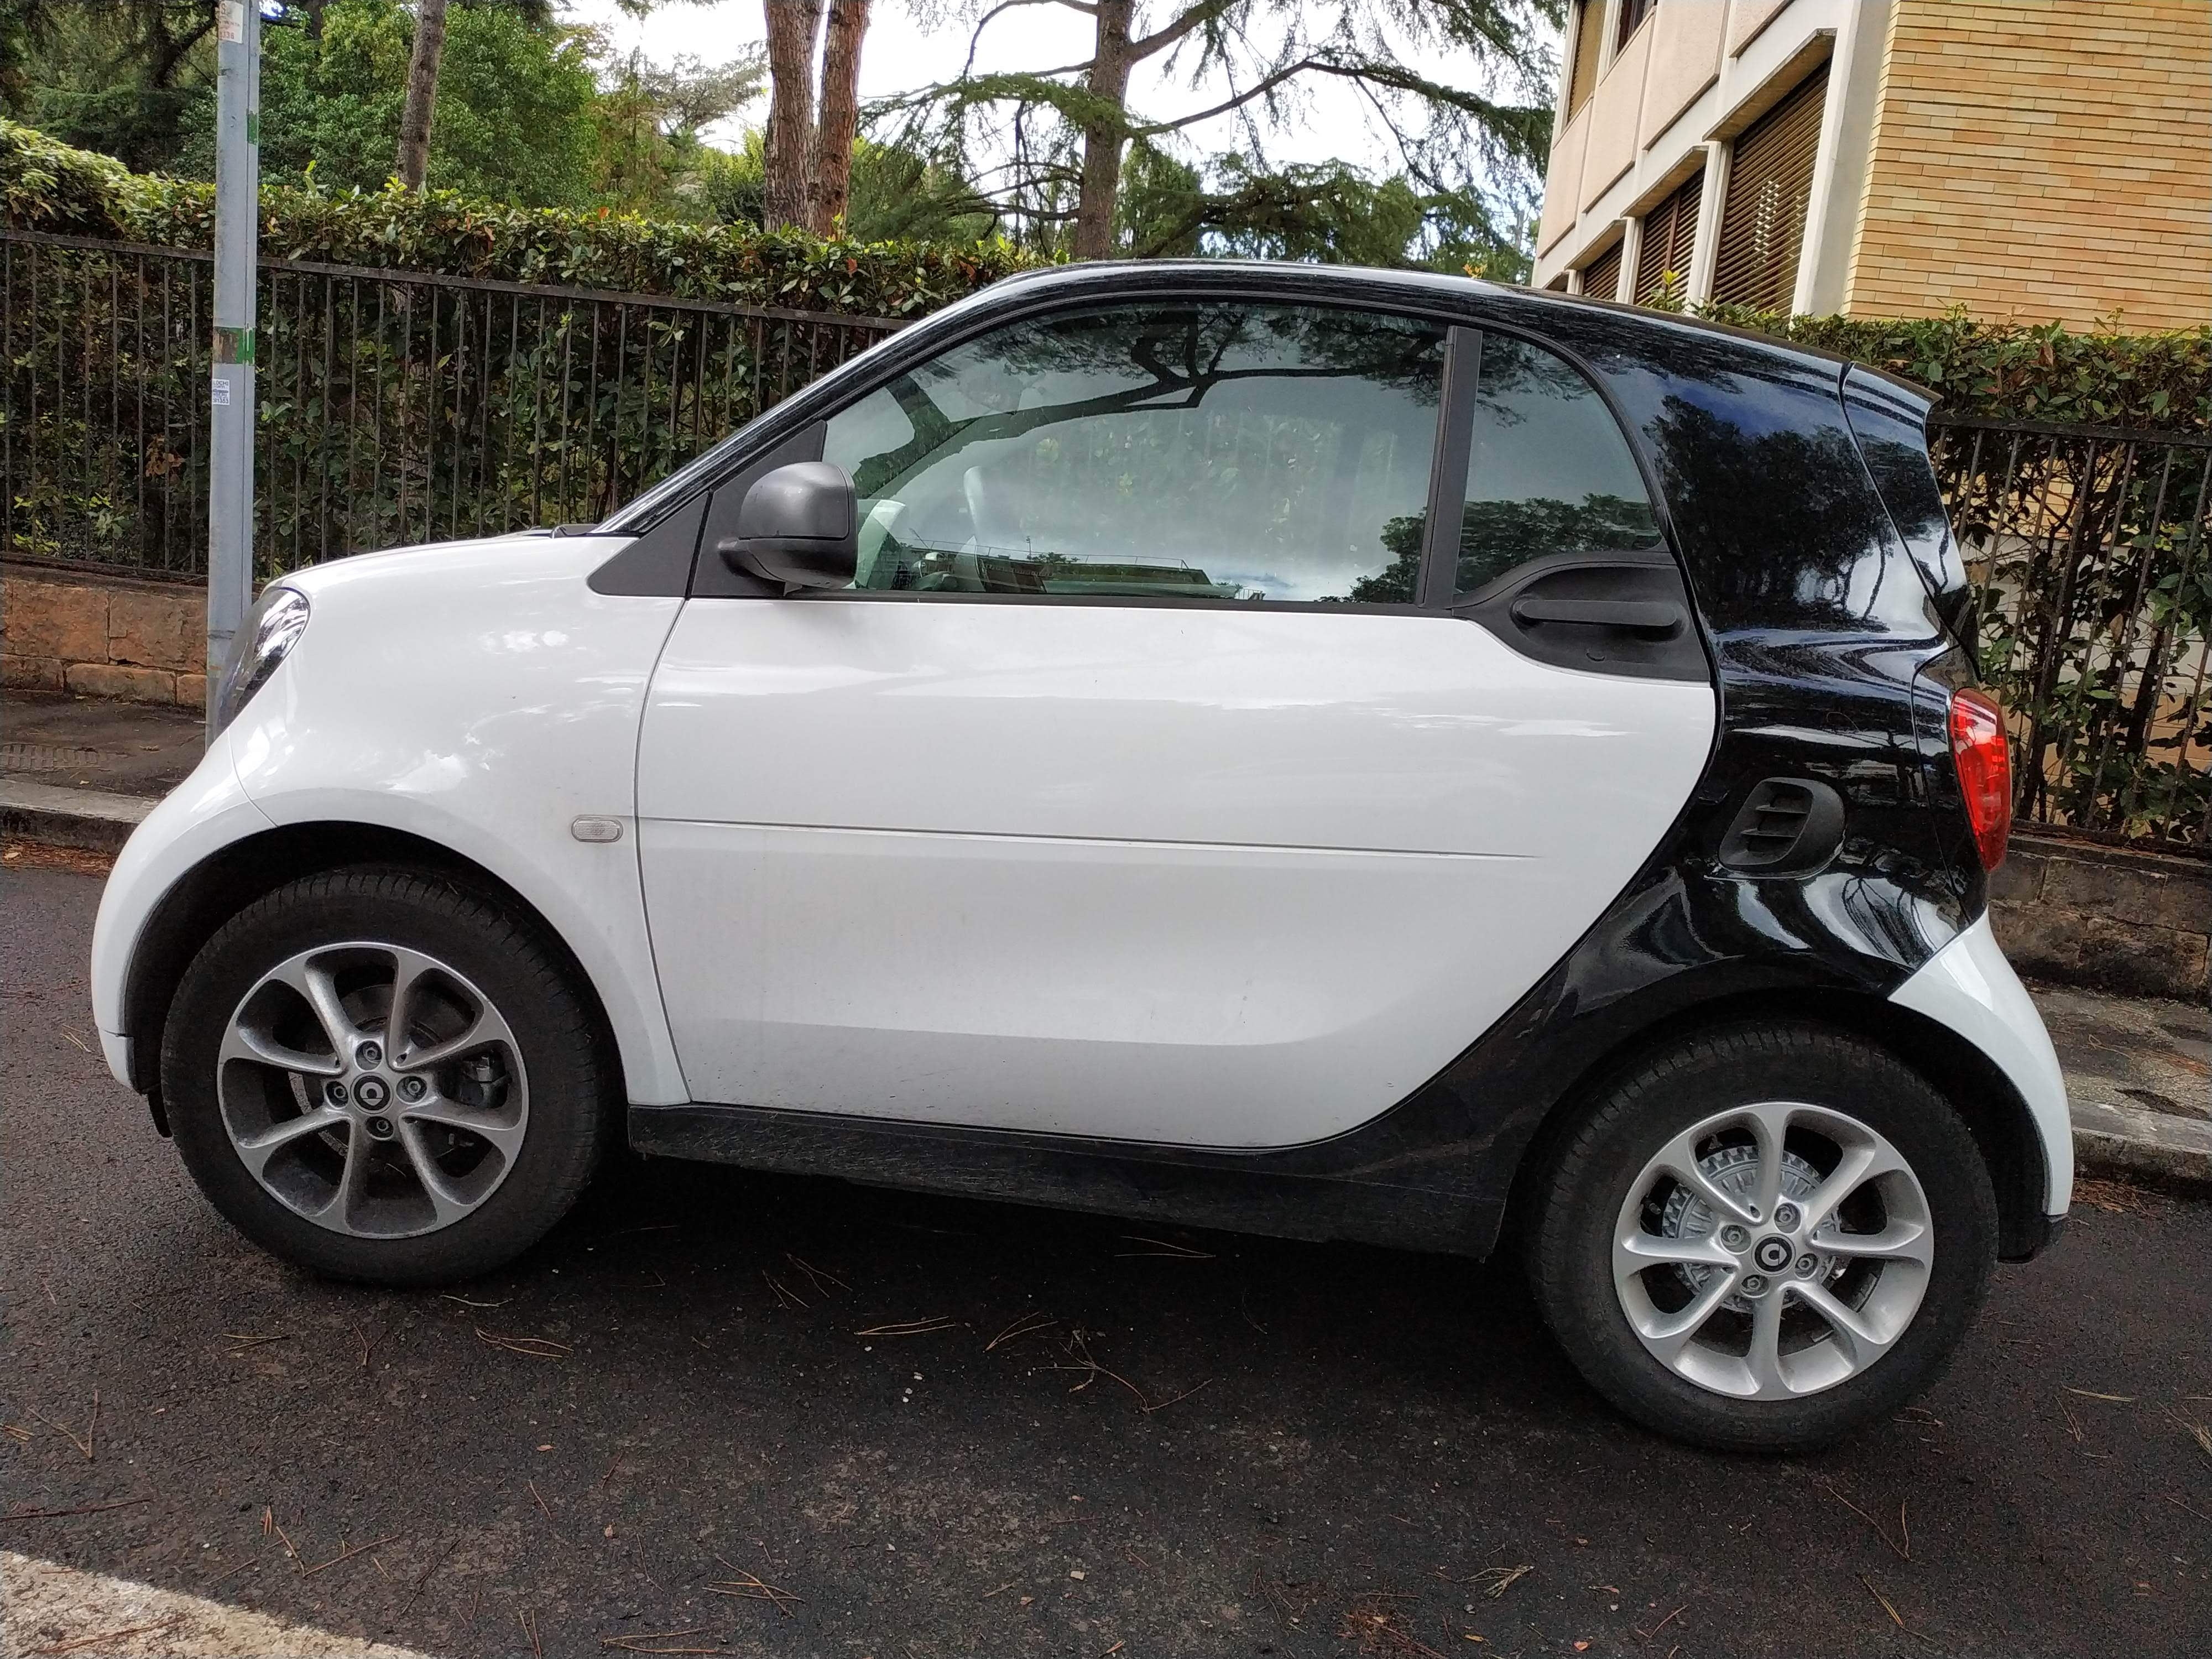

In [5]:
# Let's give a look to 3 random images from the data
import IPython.display as display

for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))

In [6]:
# Define labels for all images

#find all labels in alphabetic order (each class is contained in a separate folder)
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['back', 'front', 'side']

In [7]:
# Define indexes of every group
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'back': 0, 'front': 1, 'side': 2}

In [8]:
# Create a list of all image labels
all_image_label = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]
all_image_labels = []
for label in all_image_label:
    if label == 0:
        label = [1,0,0]
    elif label == 1:
        label = [0,1,0]
    elif label == 2:
        label = [0,0,1]
    all_image_labels.append(label) 
print("First 10 labels indices: ", all_image_label[:10])
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [2, 2, 2, 0, 1, 1, 2, 2, 2, 0]
First 10 labels indices:  [[0, 0, 1], [0, 0, 1], [0, 0, 1], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 0, 1], [0, 0, 1], [0, 0, 1], [1, 0, 0]]


In [9]:
# translate all labels to the "float32" format
a = []
for lab in all_image_labels:
    k = []
    for i in lab:
        k.append(float(i))
    a.append(k)
all_image_labels = a

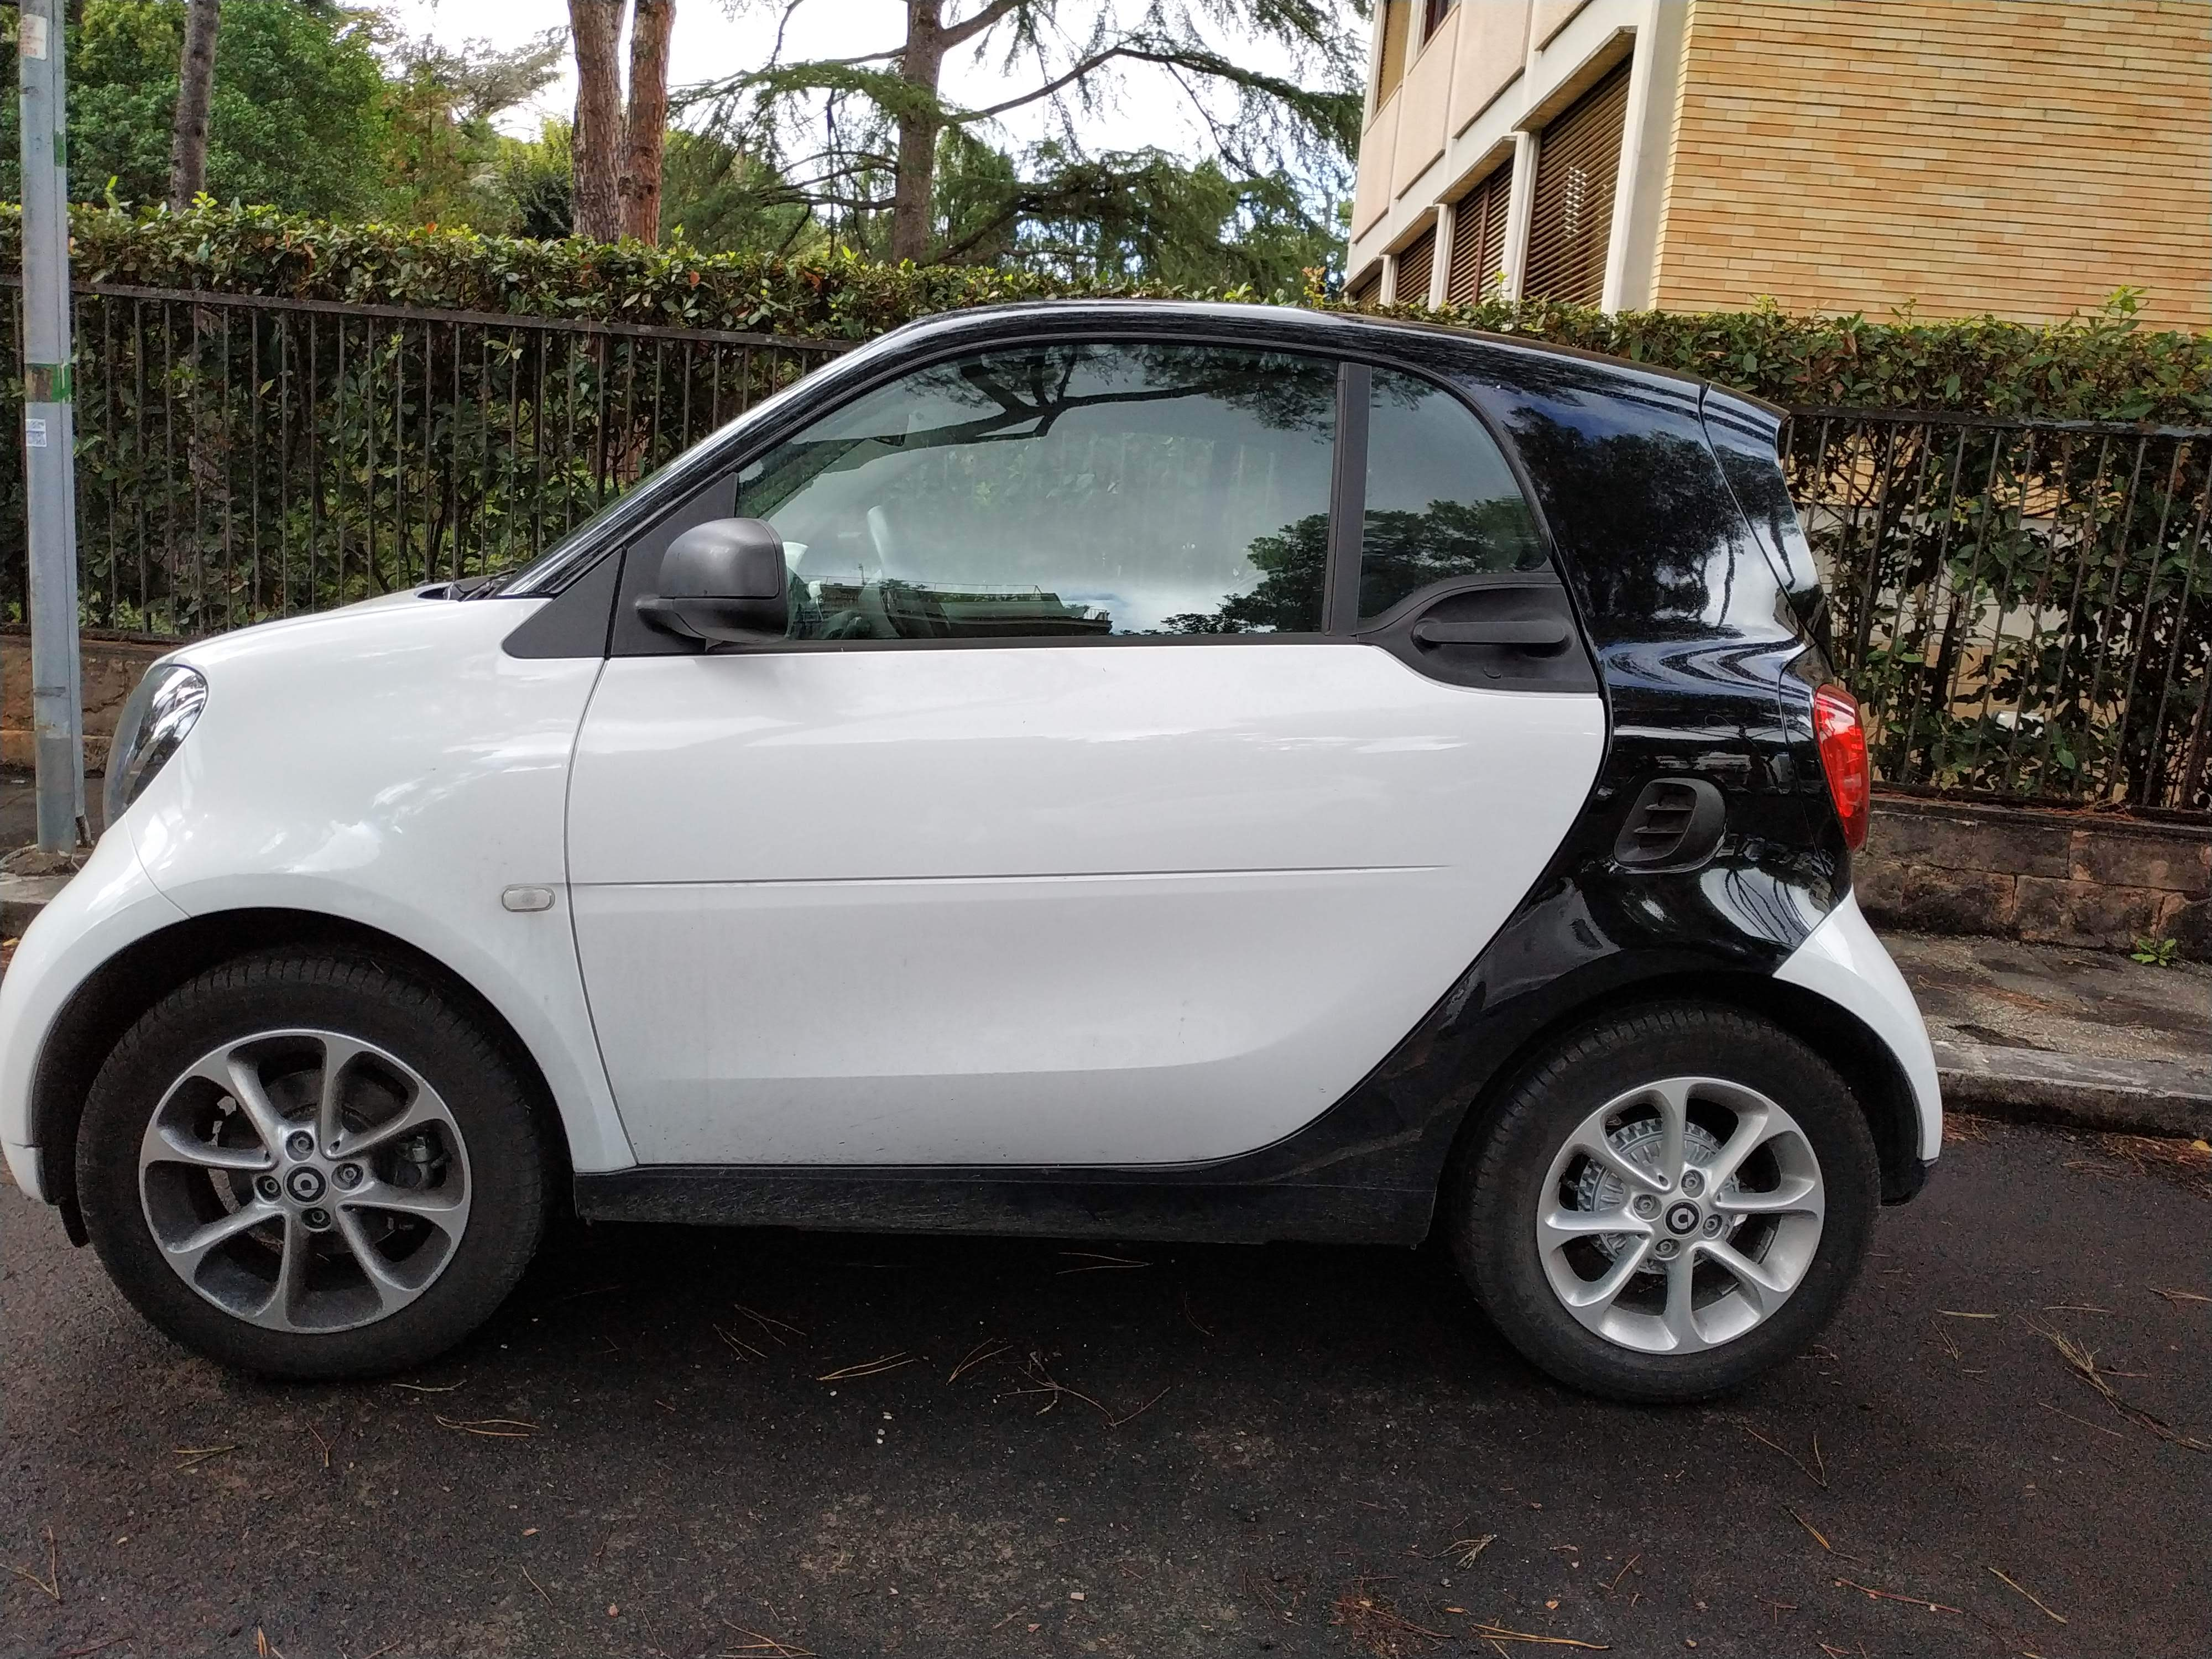

'D:\\Programming\\Jupyter Notebook Works\\GANs\\cGAN\\Input_car_train\\side\\IMG_20191016_120108_BURST13.jpg'

In [10]:
# The way to the image and the image are following
img_path = all_image_paths[0]
display.display(display.Image(img_path))
img_path

## Load images and define its preprocessing

In [11]:
import os
import sys
from PIL import Image
import numpy as np

def preprocess_image(photo):
    img = Image.open(photo)
    img = img.convert('L')
    dim = (36,36)
    img = img.resize(dim)
    imgVec = np.array(img)
    imgVec = imgVec.flatten()
    imgVec = imgVec / np.linalg.norm(imgVec) #normalize the flatten vector
    
    image_list = []
    for elem in imgVec:
        image_list.append(elem)
    return image_list
len(preprocess_image(img_path))

1296

## Let's make a dataset


In [12]:
# All images -> to the np.float32 array
all_images = []
for path in all_image_paths:
    img = preprocess_image(path)
    all_images.append(img)
all_images = np.array(all_images)
all_images = np.float32(all_images)
all_images.shape

(270, 1296)

In [13]:
# Create a dataset
DATASET = tf.data.Dataset.from_tensor_slices((all_images,all_image_labels))
DATASET

<TensorSliceDataset shapes: ((1296,), (3,)), types: (tf.float32, tf.float32)>

### To train a model successfully on this dataset we need:

* To mix the dataset very well.
* To create batches.
* To deploy unlimited data repeating.
* To allow very good speed of batches obtaining.

In [14]:
BATCH_SIZE = 64

# buffer_size = image_count to enable mixing of all the data
ds = DATASET.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` allows to the model to extract next batches already during the previous step execution
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((?, 1296), (?, 3)), types: (tf.float32, tf.float32)>

In [15]:
# Let's make the dataset iterable
iter = ds.make_initializable_iterator()
X,y = iter.get_next()

In [16]:
#Check whether the iterator works or not
# with tf.Session() as sess:
#     sess.run(iter.initializer)
#     for i in range(3):
#         print(sess.run(y[:4]))
#     for j in range(3):
#         print(sess.run(y[:4]))
    
    
#     print(sess.run(y[:5]))
#     print(sess.run(y[:5]))

## Model creation

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [18]:
# Define sizes of the data

Z_dim = 100
X_dim = 1296
y_dim = 3
h_dim = 1024

In [19]:
# Random normal distribution
def rnd_distr(size):
    in_dim = size[0]
    rnd_distr = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=rnd_distr)

In [20]:
""" Discriminator Net model """
D_W1 = tf.Variable(rnd_distr([X_dim + y_dim, h_dim]), name = "D_W1")
tf.summary.histogram("D_W1",D_W1)
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]), name = "D_b1")
tf.summary.histogram("D_b1",D_b1)

D_W2 = tf.Variable(rnd_distr([h_dim, 1]), name = "D_W2")
tf.summary.histogram("D_W2",D_W2)
D_b2 = tf.Variable(tf.zeros(shape=[1]), name = "D_b2")
tf.summary.histogram("D_b2",D_b2)

theta_D = [D_W1, D_W2, D_b1, D_b2]

def discriminator(x, y):
    with tf.name_scope("Discriminator"):
        inputs = tf.concat(axis=1, values=[x, y])
        D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
        D_logit = tf.matmul(D_h1,D_W2)+D_b2
        D_prob = tf.nn.sigmoid(D_logit)

        return D_prob, D_logit

In [21]:
""" Generator Net model """
Z = tf.placeholder(tf.float32, shape=[None, Z_dim],  name = "Z")

G_W1 = tf.Variable(rnd_distr([Z_dim + y_dim, h_dim]), name = "G_W1")
tf.summary.histogram("G_W1",G_W1)
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]), name = "G_b1")
tf.summary.histogram("G_b1",G_b1)

G_W2 = tf.Variable(rnd_distr([h_dim, X_dim]), name = "G_W2")
tf.summary.histogram("G_W2",G_W2)
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]), name = "G_b2")
tf.summary.histogram("G_b2",G_b2)

theta_G = [G_W1, G_W2, G_b1, G_b2]

def generator(z, y):
    with tf.name_scope("Generator"):
        inputs = tf.concat(axis=1, values=[z, y])
        G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
        G_log_prob = tf.matmul(G_h1,G_W2)+G_b2
        G_prob = tf.nn.sigmoid(G_log_prob)

        return G_prob

In [22]:
# random noise initializator
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

In [23]:
# function to plot 4*4 images 
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(36, 36), cmap='Greys_r')

    return fig

In [24]:
# Let's define the model
G_sample = generator(Z, y)
D_real, D_logit_real = discriminator(X, y)
D_fake, D_logit_fake = discriminator(G_sample, y)

with tf.name_scope("D_loss"):
    D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
    D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
    D_loss = D_loss_real + D_loss_fake
    tf.summary.scalar("D_loss",D_loss)
with tf.name_scope("G_loss"):
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
    tf.summary.scalar("G_loss",G_loss)
with tf.name_scope("Train"):
    D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
    G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [25]:
merged_summary = tf.summary.merge_all()

In [26]:
#let's organize to save the model
saver = tf.train.Saver()

#if we want to load the model trom an already existing one we need co state it as TRUE
restore = False

#if we want to allocate only a certain percent of the GPU memory 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7 #and then put the config to tf.Session(config=config)

In [27]:
# Define training process
def model_training(epochs):
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    sess.run(iter.initializer)
    
    #Let's play with tensorboard
    tensorboard_path = 'tensorboards/'
    if not os.path.exists(tensorboard_path):
        os.makedirs(tensorboard_path)

    writer = tf.summary.FileWriter(tensorboard_path)
    writer.add_graph(sess.graph)
    
    if not os.path.exists('out/'):
        os.makedirs('out/')

    weights_path = 'model_weights/'
    if not os.path.exists(weights_path):
        os.makedirs(weights_path)

    i = 0

    #if we want to restore an already existing model
    if restore == True:
        checkpoint = tf.train.latest_checkpoint(weights_path)
        saver.restore(sess, checkpoint)

    for it in range(EPOCHS):

        if it % 10000 == 0:
            #let's save the model every 10000 epochs
            saver.save(sess,os.path.join(weights_path, "model"),global_step=it)
            
        # every 1000 iterations we will paint pictures and save them to the path
        if it % 1000 == 0:
            Z_sample = sample_Z(BATCH_SIZE, Z_dim)
            s = sess.run(merged_summary, feed_dict={Z: Z_sample})
            writer.add_summary(s,it)
            
        #we will add data to the tensorboard every 1000 iterations
        if it % 1000 == 0:
            n_sample = 16
            Z_sample = sample_Z(n_sample, Z_dim)

            # {'back': 0, 'front': 1, 'side': 2}
            y_sample = np.zeros(shape=[n_sample, y_dim]) #create n_sample lines of zeros (16) 
            y_sample[:, 0] = 1 #does all the y-labels with preferred value

            samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})
            
            fig = plot(samples)
            plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
            i += 1
            plt.close(fig)

        #We will train during one iteration: 5 times D -> 2 times G to allow better competition quality
        for dt in range(5):
            Z_sample = sample_Z(BATCH_SIZE, Z_dim)
            _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={Z: Z_sample})
        for gt in range(2):
            Z_sample = sample_Z(BATCH_SIZE, Z_dim)
            _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_sample})

        if it % 1000 == 0:
            print('Iter: {}'.format(it))
            print('D loss: {:.4}'. format(D_loss_curr))
            print('G_loss: {:.4}'.format(G_loss_curr))
            print("CPU usage %: "+ str(psutil.cpu_percent()))
            print()
    sess.close()

In [28]:
"""Results checking"""
def model_using(object_to_paint):
    # {'paper': 0, 'scissors': 1, 'stone': 2}
    
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    
    weights_path = 'model_weights/'
    checkpoint = tf.train.latest_checkpoint(weights_path)
    saver.restore(sess, checkpoint)
    
    if not os.path.exists('out_check/'):
        os.makedirs('out_check/')

    n_sample = 16
    a = 0

    Z_sample = sample_Z(n_sample, Z_dim)
    y_sample = np.zeros(shape=[n_sample, y_dim]) #create n_sample lines of zeros (16) 
    y_sample[:, 0] = object_to_paint #does all the y-labels with preferred value

    samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})

    fig = plot(samples)
    plt.savefig('out_check/{}.png'.format(str(a).zfill(3)), bbox_inches='tight')
    a += 1
    plt.close(fig)
    
    sess.close()

In [29]:
# How to define CPU usage?
import psutil
# gives a single float value
print("CPU usage %: "+ str(psutil.cpu_percent()))

CPU usage %: 0.0


In [30]:
#Let's define a training process:

EPOCHS = 90001 #better to make it dividable to 10000+1
train_turns = 1 #a number of training loops of specified epochs
counter = 0

for train_turn in range(train_turns):
    if counter > 0:
        restore = True
    print("Training loop %.0f started\n"%(train_turn+1))
    model_training(EPOCHS)
    counter +=1 

Training loop 1 started

Iter: 0
D loss: 0.9424
G_loss: 11.33
CPU usage %: 38.2

Iter: 1000
D loss: 0.003533
G_loss: 7.508
CPU usage %: 95.0

Iter: 2000
D loss: 0.01955
G_loss: 7.981
CPU usage %: 94.9

Iter: 3000
D loss: 0.01601
G_loss: 6.205
CPU usage %: 94.9

Iter: 4000
D loss: 0.01122
G_loss: 4.366
CPU usage %: 94.3

Iter: 5000
D loss: 0.02878
G_loss: 4.749
CPU usage %: 94.8

Iter: 6000
D loss: 0.01573
G_loss: 5.796
CPU usage %: 94.8

Iter: 7000
D loss: 0.01847
G_loss: 5.341
CPU usage %: 94.9

Iter: 8000
D loss: 0.0269
G_loss: 4.417
CPU usage %: 95.1

Iter: 9000
D loss: 0.01587
G_loss: 6.56
CPU usage %: 94.9

Iter: 10000
D loss: 0.0293
G_loss: 4.033
CPU usage %: 97.6

Iter: 11000
D loss: 0.0127
G_loss: 5.267
CPU usage %: 94.6

Iter: 12000
D loss: 0.04096
G_loss: 7.711
CPU usage %: 94.8

Iter: 13000
D loss: 0.02547
G_loss: 5.429
CPU usage %: 94.8

Iter: 14000
D loss: 0.01355
G_loss: 6.34
CPU usage %: 94.7

Iter: 15000
D loss: 0.01627
G_loss: 4.318
CPU usage %: 94.8

Iter: 16000
D los

In [39]:
#Let's check the result of a trained model
# {'back': 0, 'front': 1, 'side': 2}
model_using(0)

INFO:tensorflow:Restoring parameters from model_weights/model-90000
